# 特征匹配与全景拼接

# 1. Brute-Force蛮力匹配

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img1 = cv2.imread('01_Picture/19_Box.png',0)
img2 = cv2.imread('01_Picture/20_Box_in_scene.png',0)

In [4]:
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
cv_show('img1',img1)
cv_show('img2',img2)

In [6]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# crossCheck 表示两个特征点要互相匹配，例如 A 中的第 i 个特征点与 B 中第 j 个特征点最近的，并且 B 中第 j 个特征点到 A 中的第 i 个特征点也是最近的。      
# 将两幅图像的特征点、特征向量算出来，用欧氏距离去比较特征向量相似性，一般情况下默认用的是归一化后的欧式距离去做，为了使得结果更均衡些。
# 如果不用 sift 特征计算方法去做，而是用其他特征计算方法需要考虑不同的匹配方式。
bf = cv2.BFMatcher(crossCheck = True)  # cv2.BFMatcher 蛮力匹配缩写

# 2. 1对1的匹配

In [7]:
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)  # 画前十个点          
cv_show('img3',img3)

# 3. k对最佳匹配

① 如果需要更快速完成操作，可以尝试使用 cv2.FlannBasedMatcher。

In [8]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2) # k 参数可选，可以一个点跟它最近的k个点可选         

good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:  # m.distance 与 n.distance 比值小于 0.75，这是自己设定的过滤条件   
        good.append([m])
        
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
cv_show('img3',img3)

# 4. 随机抽样一致算法 (RANSAC)

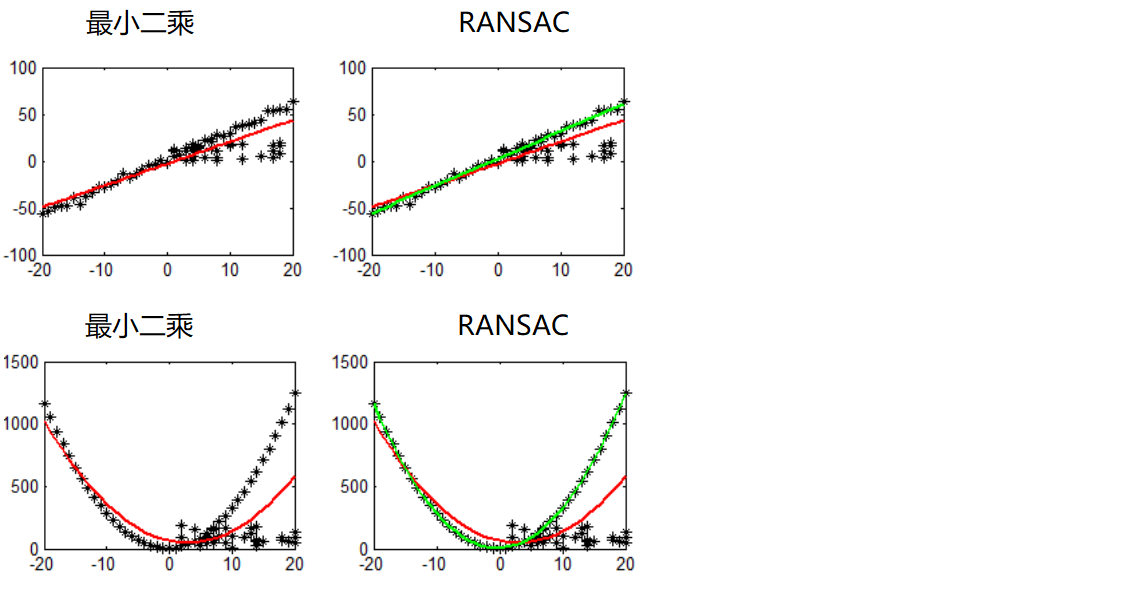

① 选择初始样本点进行拟合，给定一个容忍范围，不断进行迭代。

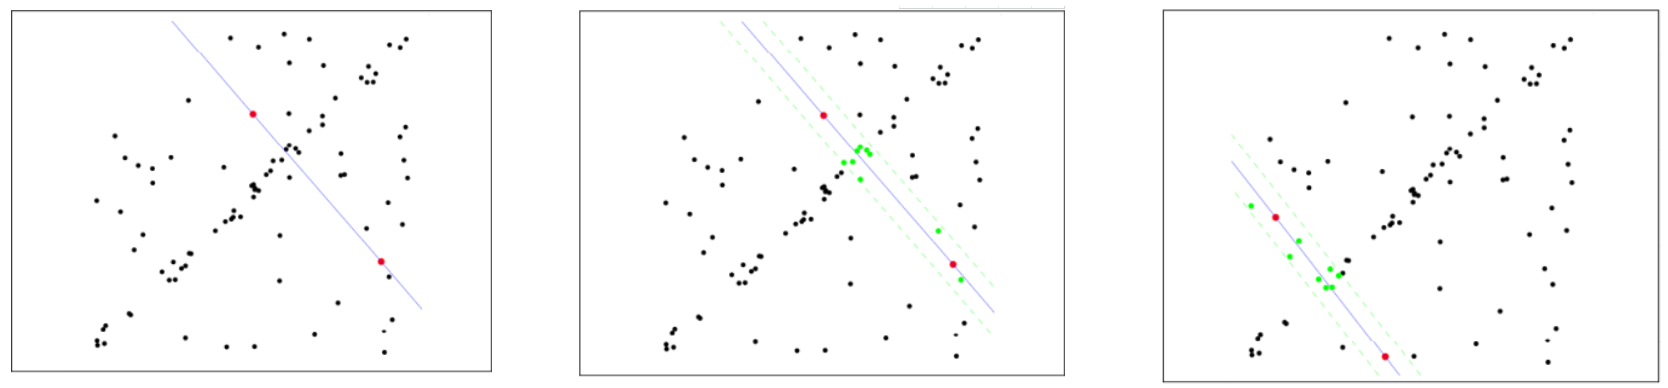

② 每一次拟合后，容差范围内都有对应的数据点数，找出数据点个数最多的情况，就是最终的拟合结果。

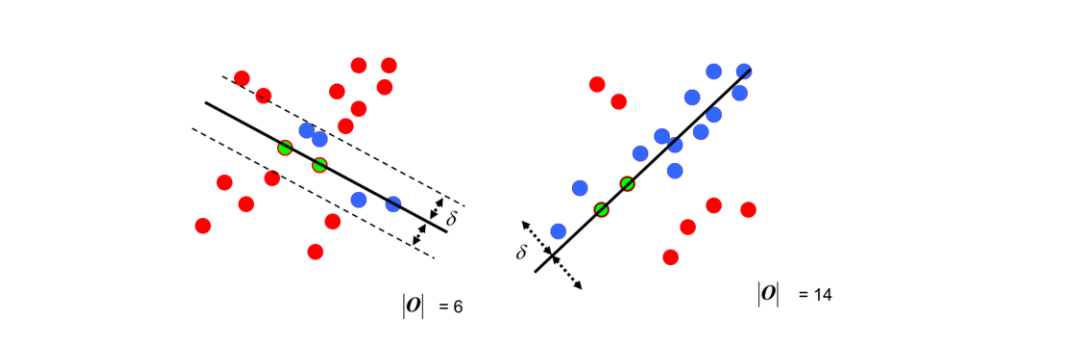

# 5. 单应性矩阵

① 一对点 (x',y') 与 (x,y) 只能列两个方程，因此八个未知数需要至少四对点。

② 通过 loss 找出四队最好配对的特征点。

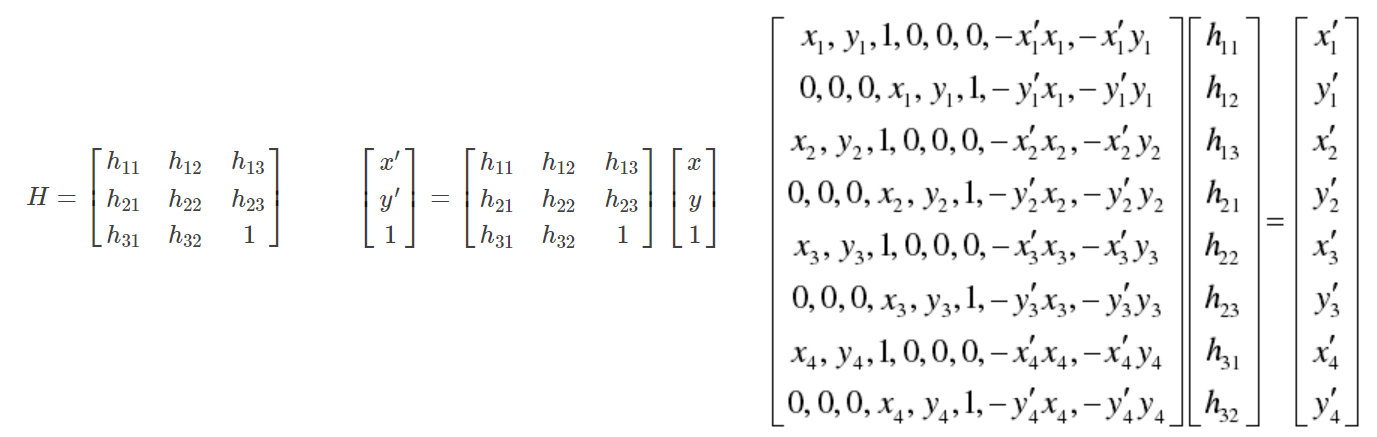

# 6. 全景拼接

In [9]:
import numpy as np
import cv2

class Stitcher:

    #拼接函数
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        #获取输入图片
        (imageB, imageA) = images
        #检测 A、B 图片的 SIFT 关键特征点，并计算特征描述子
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 匹配两张图片的所有特征点，返回匹配结果
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)           

        # 如果返回结果为空，没有匹配成功的特征点，退出算法
        if M is None:
            return None

        # 否则，提取匹配结果
        # H是3x3视角变换矩阵      
        (matches, H, status) = M
        # 将图片A进行视角变换，result是变换后图片
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        self.cv_show('result', result)
        # 将图片B传入result图片最左端
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        self.cv_show('result', result)
        # 检测是否需要显示图片匹配
        if showMatches:
            # 生成匹配图片
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # 返回结果
            return (result, vis)

        # 返回匹配结果
        return result
    
    def cv_show(self,name,img):
        cv2.imshow(name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def detectAndDescribe(self, image):
        # 将彩色图片转换成灰度图
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 建立 SIFT 生成器
        descriptor = cv2.xfeatures2d.SIFT_create()
        # 检测 SIFT 特征点，并计算描述子
        (kps, features) = descriptor.detectAndCompute(image, None)

        # 将结果转换成 NumPy 数组
        kps = np.float32([kp.pt for kp in kps])

        # 返回特征点集，及对应的描述特征
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.BFMatcher()
  
        # 使用 KNN 检测来自 A、B 图的SIFT特征匹配对，K=2
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # 当最近距离跟次近距离的比值小于 ratio 值时，保留此匹配对
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            # 存储两个点在 featuresA, featuresB 中的索引值
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 当筛选后的匹配对大于 4 时，计算视角变换矩阵
        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算视角变换矩阵
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # 返回结果
            return (matches, H, status)

        # 如果匹配对小于4时，返回None
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 初始化可视化图片，将A、B图左右连接到一起
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 联合遍历，画出匹配对
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # 当点对匹配成功时，画到可视化图上
            if s == 1:
                # 画出匹配对
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # 返回可视化结果
        return vis

In [10]:
import cv2

# 读取拼接图片
imageA = cv2.imread("01_Picture/21_Left_01.png")
imageB = cv2.imread("01_Picture/22_Right_01.png")

# 把图片拼接成全景图
stitcher = Stitcher()  # 实例化 Stitcher 对象
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

# 显示所有图片
cv2.imshow("Image A", imageA)
cv2.imshow("Image B", imageB)
cv2.imshow("Keypoint Matches", vis)
cv2.imshow("Result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()